# Multilevel Delayed Acceptance - Bayesian Linear Regression

*Tim Dodwell, University of Exeter and The Alan Turing Insitute, t.dodwell@exeter.ac.uk. Updated 23/9/20.*

Our first example considers a simple Bayesian Linear Regression problem using a dataset from health statistics. The **bodyfat** data set, available [data here](https://github.com/merliseclyde/BAS), provides body fat measurements of $N = 253$ males (${\bf d}$), alongside measurements of the circumference of their abdomens (${\bf x}$). Body fat is recognised as a good metric for determining the general health of an individual, however it is much more complex to measure compared with measuring abdomen circumference.  

From the dataset,  see below, it is reasonable to build a predictive model between the two parameters defined by a simple linear relationship. We therefore define the {\em observation model} between our model and data as

\begin{equation}
{\bf d} = \beta_0 + \beta_1 {\bf x} + \epsilon, \quad \mbox{where} \quad \epsilon \sim \mathcal N(0, \sigma^2 \mathbb I_N).
\end{equation}

The aim is to determine the distribution of the three parameters $\theta = [\beta_0, \beta_1, \sigma^2]^T$, given our complete dataset ${\bf d}$, i.e. obtain samples from $\pi(\theta|{\bf d})$. Independent, weakly informative, priors are specified for each parameter such that

$$
\beta_0 \sim \mathcal N(-40.0,5.0^2), \quad \beta_1 \sim \mathcal N(0.65, 2.0^2) \quad \mbox{and} \quad \sigma^2 \sim \mbox{Inv-Gamma}(3, 46).
$$

To test adaptive MLDA on this first example, a simple two-level hierarchy is constructed by generating a coarse model consisting of $20\%$ of the total data set, denoted ${\bf d}_0 \subset {\bf d}$. This approximate model is therefore $1/5$th of the cost of the full model.


In this example, to demonstrate the Multilevel variance reduction we define the Quantity of Interest ($Q$) for our problem. Recent communications from the UK's National Health Service suggest that a body fat percentage of $<17\%$ is healthy for a male. We therefore define $Q$ as the predicted abdomen circumference associated with $17\%$ body fat, i.e. 

\begin{equation}
Q(\theta) = (17\% - \beta_0 - \epsilon) /\beta_1, \quad \mbox{where} \quad \epsilon \sim \mathcal N(0, \sigma^2)
\end{equation}

for which we wish to estimate 

$$\mathbb E_{\pi(\theta|\mathcal D)} [Q] = \int_{\Theta} Q(\theta)\pi(\theta|\mathcal D)\;d\theta.$$

### Import modules

In [1]:
import os as os
import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import pandas as pd

RANDOM_SEED = 1555
np.random.seed(RANDOM_SEED)

## Load Data and Visualise Data Sets



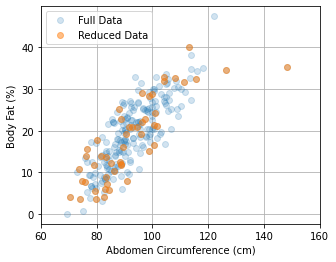

In [2]:
df = pd.read_csv('data/bodyfat.csv')

Data = df[["Bodyfat","Abdomen"]].to_numpy()

_, ax = plt.subplots(figsize=(5, 4))
ax.plot(Data[:,1],Data[:,0], "o", alpha = 0.2, label="Full Data")
ax.plot(Data[0:50,1],Data[0:50,0], "o", alpha = 0.5, label="Reduced Data")
ax.set_facecolor('w')
ax.set_ylabel("Body Fat (%)")
ax.set_xlabel("Abdomen Circumference (cm)")
ax.set_xticks([60., 80, 100., 120., 140., 160.])
ax.legend();
plt.savefig("bodyFat_data.pdf")
plt.grid()

## Define Model Dependent class

In [3]:
class BodyFat(tt.Op):
    
    # Specify what type of object will be passed and returned to the Op.
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)
    
    def __init__(self, Data, pymc3_model, level = -1):
        
        self.level = level
        if(level == 0):
            self.Data = Data[0:50,:] # Thins Data for Coarse Model
        else:
            self.Data = Data
        
        self.pymc3_model = pymc3_model
        
        
    def perform(self, node, inputs, outputs):
        
        # the method that is used when calling the Op
        
        X, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = -np.mean((X[0] + X[1]*self.Data[:,1] - self.Data[:,0])**2)/(2.0 * X[2])
        
        Q = (17.0 - X[0]- np.random.normal(0.0, np.sqrt(X[2]))) / X[1]
        
        self.pymc3_model.Q.set_value(Q) # Store QoI
        
        outputs[0][0] = np.array(logl)  # output the log-likelihood
        

## Build Hierarchy of PyMC3 Models

In [4]:
logl = []
modelHierarchy = []

maxLevel = 2

for j in range(maxLevel):

    with pm.Model() as model:

        Q = pm.Data('Q', np.float(0.0))

        # Define priors
        beta0 = pm.Normal('beta0', mu= -40.0, sigma=5.)
        beta1 = pm.Normal('beta1', mu=0.5, sigma=2.0)
        sig = pm.InverseGamma('sig2', alpha=3.0, beta=46.0)

        # wrap parameters to tensor vector
        theta = tt.as_tensor_variable([beta0, beta1, sig])

        # Build instances of "BodyFat" class for level j
        logl.append(BodyFat(Data, model, j))

        pm.Potential('likelihood', logl[j](theta))

        modelHierarchy.append(model)

## MLDA Sampling

In [5]:
numSamples = 1000
numChains = 2
numCores = 1
burnIn = 100
subSampling = [5]

with modelHierarchy[-1]: # with the finest level model
    
    step = pm.MLDA(coarse_models=[modelHierarchy[0]],
                   subsampling_rates=[subSampling],
                   variance_reduction=True,
                   store_Q_fine=True)
    
    trace = pm.sample(draws=numSamples, chains=numChains, cores = numCores, tune=burnIn, step=step, discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)

    

/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/pymc3-3.8-py3.8.egg/pymc3/step_methods/metropolis.py:994: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
Sequential sampling (2 chains in 1 job)
MLDA: [sig2, beta1, beta0]


## Show summary statistics for model parameters

In [6]:
pm.stats.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,-39.755,4.969,-48.842,-30.002,0.251,0.178,392.0,392.0,388.0,750.0,1.01
beta1,0.641,0.087,0.478,0.772,0.005,0.003,348.0,348.0,304.0,565.0,1.01
sig2,35.163,42.834,5.826,81.816,1.616,1.143,703.0,703.0,779.0,935.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c9720d0>,
      dtype=object)

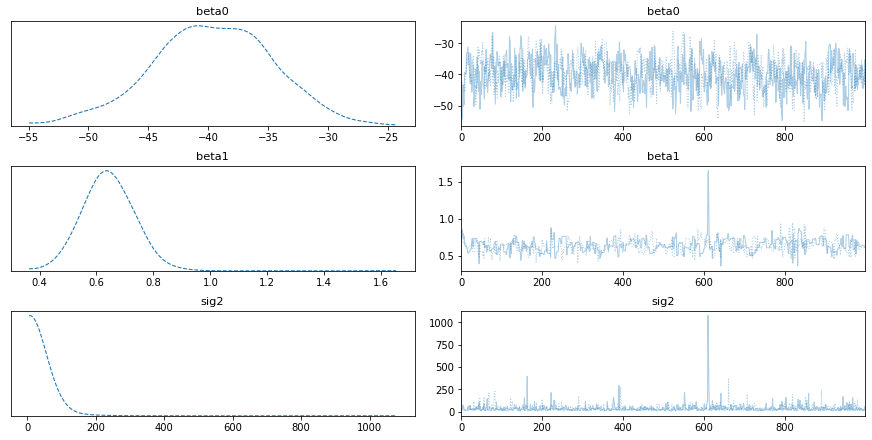

In [8]:
pm.plots.traceplot(trace, combined = True)

In [ ]:
pm.stats.summary(trace1)

# Plots for publication

The general plotting in pymc3 does not provide general flexibility to build your own more complex figures. We therefore unwrap the traces, and build our own plots using the python package seaborn in combination with matplotlib

In [ ]:
import seaborn as sns

var_names = ['beta0', 'beta1', 'sig']

samples = [] 

for i in range(len(var_names)):
    
    tmp = trace.get_values(var_names[i])
    
    samples.append(tmp.reshape((numSamples + burnIn, numChains)))
    
    
 


## need to write code which unwraps these and the removes burnin

## converts to data frame

## plots in seaborn

#numpy_data = np.array([[1, 2], [3, 4]])
#df = pd.DataFrame(data=numpy_data, index=["row1", "row2"], columns=["column1", "column2"])

In [ ]:
chain_prop = {"linewidth": (.5, 1, 2, 3)}
az.plot_trace(
    trace, combined=True, chain_prop=chain_prop, compact=False, legend=True
);

In [ ]:
with pm.Model() as model:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data('Q', np.float(0.0))

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)
    
    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])
    
    # Here we instatiate a Likelihood object using the class defined above 
    # and we add to the mout list. We pass the fine data x and y
    # and the fine pymc3 model model. This creates a fine likelihood.
    mout.append(Likelihood(x, y, model))
    
    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential('likelihood', mout[-1](theta))
    
    # MLDA with variance reduction
    step_with = pm.MLDA(coarse_models=coarse_models,                
                subsampling_rates=nsub,
                variance_reduction=True)
    
    # MLDA without variance reduction
    step_without = pm.MLDA(coarse_models=coarse_models,                
                subsampling_rates=nsub,
                variance_reduction=False,
                store_Q_fine=True)
    
    # sample
    trace1 = pm.sample(draws=ndraws, step=step_with,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)
    
    trace2 = pm.sample(draws=ndraws, step=step_without,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)

### Show stats summary

In [ ]:
pm.stats.summary(trace1)

In [ ]:
pm.stats.summary(trace2)

### Show traceplots

In [ ]:
pm.plots.traceplot(trace1)

In [ ]:
pm.plots.traceplot(trace2)

### Estimate standard error of two methods
Compare standard error of Q estimation between:
- Standard approach: Using only Q values from the fine chain (Q_2) - samples from MLDA without VR
- Telescopic sum-like (VR) approach: Using Q values from the coarsest chain (Q_0), plus all estimates of differences between levels (in this case Q_1_0 and Q_2_1) - samples from MLDA with VR

#### 1) Extract quantities of interest from the traces
This requires some reshaping with numpy

In [ ]:
# MLDA without VR
Q_2 = trace2.get_sampler_stats("Q_2").reshape((nchains, ndraws))

# MLDA with VR
Q_0 = np.concatenate(trace1.get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace1.get_sampler_stats("Q_1_0")).reshape((nchains, ndraws * nsub))
Q_2_1 = np.concatenate(trace1.get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))

# Estimates
Q_mean_standard = Q_2.mean()
Q_mean_vr = Q_0.mean() + Q_1_0.mean() + Q_2_1.mean()

print(f"Q_0 mean = {Q_0.mean()}")
print(f"Q_1_0 mean = {Q_1_0.mean()}")
print(f"Q_2_1 mean = {Q_2_1.mean()}")
print(f"Q_2 mean = {Q_2.mean()}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")

#### Calculate variances of Q quantity samples
This shows that the variances of the differences is orders of magnitude smaller than the variance of any of the chains

In [ ]:
Q_2.var()

In [ ]:
Q_0.var()

In [ ]:
Q_1_0.var()

In [ ]:
Q_2_1.var()

#### Calculate standard error of each term using ESS

In [ ]:
ess_Q0 = az.ess(np.array(Q_0, np.float64))
ess_Q_1_0 = az.ess(np.array(Q_1_0, np.float64))
ess_Q_2_1 = az.ess(np.array(Q_2_1, np.float64))
ess_Q2 = az.ess(np.array(Q_2, np.float64))

In [ ]:
# note that the chain in level 2 has 25 times fewer samples than the chain in level 0 (because nsub=5)
print(ess_Q2, ess_Q0, ess_Q_1_0, ess_Q_2_1, ess_Q2)

Standard errors are estimated by $Var(Q) \over ESS(Q)$. 
It is clear that the differences have standard errors much lower than levels 0 and 2

In [ ]:
Q_2.var()/ess_Q2

In [ ]:
Q_0.var()/ess_Q0

In [ ]:
Q_1_0.var()/ess_Q_1_0

In [ ]:
Q_2_1.var()/ess_Q_2_1

#### Calculate total standard errors of the two competing estimates with different chunks of the sample
The graph shows how the errors decay when we collect more samples, demonstrating the gains of the VR technique in terms of standard error reduction.

In [ ]:
step = 100

Q2_SE = np.zeros(int(ndraws/step)-1)
Q0_SE = np.zeros(int(ndraws/step)-1)
Q_1_0_SE = np.zeros(int(ndraws/step)-1)
Q_2_1_SE = np.zeros(int(ndraws/step)-1)
E_standard_SE = np.zeros(int(ndraws/step)-1)
E_VR_SE = np.zeros(int(ndraws/step)-1)
k = 0

for i in np.arange(step, ndraws, step):
    Q2_SE[k] = Q_2[:,0:i].var() / az.ess(np.array(Q_2[:,0:i],np.float64))
    Q0_SE[k] = Q_0[:,0:i*(nsub**2)].var() / az.ess(np.array(Q_0[:,0:i*(nsub**2)],np.float64))
    Q_1_0_SE[k] = Q_1_0[:,0:i*nsub].var() / az.ess(np.array(Q_1_0[:,0:i*nsub],np.float64))
    Q_2_1_SE[k] = Q_2_1[:,0:i].var() / az.ess(np.array(Q_2_1[:,0:i],np.float64))
    E_standard_SE[k] = np.sqrt(Q2_SE[k])
    E_VR_SE[k] = np.sqrt(Q0_SE[k] + Q_1_0_SE[k] + Q_2_1_SE[k])
    k += 1

fig = plt.figure()
ax = fig.gca()

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.plot(np.arange(step, ndraws, step), E_standard_SE)
ax.plot(np.arange(step, ndraws, step), E_VR_SE)
plt.xlabel('Samples drawn', fontsize=18)
plt.ylabel('Standard error', fontsize=18)
ax.legend(['Standard estimator', 'Variance reduction estimator'])

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w